In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip install medmnist

Introduction:
Medical image classification plays a crucial role in automating diagnostic processes, aiding healthcare professionals in providing timely and accurate assessments. In this project, we leverage the MedMNIST dataset, a collection of diverse medical image datasets, to demonstrate the application of deep learning models for medical image classification.


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import medmnist
from medmnist import INFO, Evaluator
import os
import matplotlib.pyplot as plt
import re

Objective:
The primary goal of this project is to showcase the development and evaluation of two different deep learning models, ResNet-50 and a custom convolutional neural network (CustomNet), for the classification of medical images. The MedMNIST dataset, specifically the 'bloodmnist' subset, is used to train and test these models.


MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/

In [19]:
data_flag = 'bloodmnist'
download = True

NUM_EPOCHS = 50
BATCH_SIZE = 256
lr = 0.0001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [20]:
train_losses_1, train_accuracies_1 = [], []
test_losses_1, test_accuracies_1 = [], []
test_accuracies_str_1 = []

In [21]:
train_losses_2, train_accuracies_2 = [], []
test_losses_2, test_accuracies_2 = [], []
test_accuracies_str_2 = []

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

Data Preprocessing:
We begin by loading and preprocessing the MedMNIST 'bloodmnist' dataset, transforming the

images into a suitable format for training. The data is split into training and testing sets, and appropriate data loaders are created for efficient processing.



In [22]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


In [8]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0
Datas

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

Model Architecture:
Two distinct models are implemented for the classification task: ResNet-50 and a custom convolutional neural network (CustomNet). ResNet-50 is a pre-trained model known for its excellent performance on various image classification tasks. CustomNet, on the other hand, is a specifically designed architecture for this project.


In [23]:
#Def_Res50

def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
print(device)

def res50_model(num_classes, feature_extract = False, use_pretrained=True):

    model_ft = models.resnet50(pretrained=use_pretrained)
    #set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

model = res50_model(num_classes=n_classes)
model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr)#, momentum=0.9)

cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluation:

After training, the models are evaluated on both the training and testing sets. Metrics such as area under the curve (AUC) and accuracy are computed to assess the models' performance. The MedMNIST Evaluator class is utilized to obtain these metrics.


In [24]:
#Eval_Res50
def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    y_true = y_true.to(device)
    y_score = y_score.to(device)

    #print(y_true.is_cuda,y_score.is_cuda)

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.cuda(non_blocking=True)
            targets = targets.cuda(non_blocking=True)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true.to(device)
            y_score.to(device)
            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
        numbers = re.findall(r'\d+.\d+', str(metrics))
        print(numbers)
        if split == 'test':
          test_losses_1.append(numbers[0])
          test_accuracies_str_1.append(numbers[1])



Training:
The training process involves iterating through the dataset for multiple epochs, optimizing the model parameters using the Adam optimizer for ResNet-50 and SGD for CustomNet. Learning rate adjustments are made during training to enhance model performance. Both models are periodically saved to facilitate later analysis.


In [ ]:
#Train_Res50

for epoch in range(NUM_EPOCHS):
    if epoch>=50:
        lr=lr*0.9
        if epoch>=75:
            li=lr*0.9
    train_correct_1 = 0
    train_total_1 = 0
    test_correct_1 = 0
    test_total_1 = 0


    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        inputs = inputs.cuda(non_blocking=True)
        targets = targets.cuda(non_blocking=True)
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
            train_correct_1 += ((outputs > 0.5).int() == targets.int()).sum().item()
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            # Calculate the number of correct predictions
        _, predicted = outputs.max(1)
        train_correct_1 += predicted.eq(targets).sum().item()

        loss.backward()
        optimizer.step()
        train_total_1 += targets.size(0)
    train_losses_1.append(loss.item())
    train_accuracies_1.append(100 * train_correct_1 / train_total_1)

    # torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/models/res50/epoch2', f'model_epoch_{epoch}.pth'))
    print('==> Evaluating ...')
    test('train')
    test('test')

100%|██████████| 47/47 [00:05<00:00,  7.83it/s]


==> Evaluating ...
train  auc: 0.991  acc:0.905
['0.9912018461605302', '0.9054268751567857']
test  auc: 0.986  acc:0.873
['0.9861534497035696', '0.8731365097924584']


100%|██████████| 47/47 [00:05<00:00,  7.91it/s]


==> Evaluating ...
train  auc: 0.999  acc:0.973
['0.9990743541082', '0.972991052763609']
test  auc: 0.992  acc:0.905
['0.9917817439907848', '0.9052908506284713']


100%|██████████| 47/47 [00:05<00:00,  7.91it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.991
['0.9999104478357975', '0.9909691445773058']
test  auc: 0.994  acc:0.921
['0.9939492382802091', '0.9210757088570594']


100%|██████████| 47/47 [00:05<00:00,  7.85it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.989
['0.99986779056583', '0.9892967639434735']
test  auc: 0.991  acc:0.915
['0.9909974577337415', '0.9152294650686934']


100%|██████████| 47/47 [00:06<00:00,  7.78it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.994
['0.9999374264878839', '0.9941466677815871']
test  auc: 0.993  acc:0.921
['0.9929905816924963', '0.9210757088570594']


100%|██████████| 47/47 [00:06<00:00,  7.78it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.994
['0.9999572360599043', '0.9944811439083535']
test  auc: 0.992  acc:0.920
['0.9917543562647371', '0.9199064600993861']


100%|██████████| 47/47 [00:06<00:00,  7.78it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.996
['0.9999847308264214', '0.9955681913203445']
test  auc: 0.994  acc:0.926
['0.9938578871726278', '0.9263373282665888']


100%|██████████| 47/47 [00:06<00:00,  7.72it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.987
['0.9998787287968618', '0.9866209549293419']
test  auc: 0.991  acc:0.915
['0.9914347052223856', '0.9146448406898567']


100%|██████████| 47/47 [00:06<00:00,  7.66it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.994
['0.9999779512077864', '0.9939794297182039']
test  auc: 0.993  acc:0.923
['0.9929955233181453', '0.9234142063724057']


100%|██████████| 47/47 [00:06<00:00,  7.65it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.997
['0.999983418800955', '0.996738857764027']
test  auc: 0.994  acc:0.929
['0.9936226829887725', '0.9289681379713534']


100%|██████████| 47/47 [00:06<00:00,  7.24it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.997
['0.9999852355461875', '0.99740781001756']
test  auc: 0.992  acc:0.929
['0.9922225191388991', '0.9292604501607717']


100%|██████████| 47/47 [00:06<00:00,  7.60it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.999
['0.999993908139303', '0.9987457145246258']
test  auc: 0.995  acc:0.935
['0.9946866031109419', '0.9348143817597194']


100%|██████████| 47/47 [00:06<00:00,  7.57it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.999
['0.9999985228977436', '0.9989965716197007']
test  auc: 0.994  acc:0.931
['0.9942312253446219', '0.9307220111078632']


100%|██████████| 47/47 [00:06<00:00,  7.38it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.999
['0.9999980125867768', '0.9987457145246258']
test  auc: 0.994  acc:0.931
['0.9944619045757994', '0.9313066354866998']


100%|██████████| 47/47 [00:06<00:00,  7.48it/s]


==> Evaluating ...
train  auc: 1.000  acc:1.000
['0.9999999496366365', '0.9998327619366167']
test  auc: 0.994  acc:0.935
['0.9941371125491008', '0.9351066939491377']


100%|██████████| 47/47 [00:06<00:00,  7.49it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.999
['0.9999993003917087', '0.9991638096830838']
test  auc: 0.994  acc:0.937
['0.9943317699847727', '0.9371528792750657']


100%|██████████| 47/47 [00:06<00:00,  7.50it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.996
['0.9999844426934265', '0.9964043816372606']
test  auc: 0.994  acc:0.931
['0.9935808393168395', '0.9310143232972815']


100%|██████████| 47/47 [00:06<00:00,  7.48it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.998
['0.9999847367225453', '0.9977422861443265']
test  auc: 0.991  acc:0.933
['0.9908644278226783', '0.9333528208126279']


100%|██████████| 47/47 [00:06<00:00,  7.46it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.996
['0.9999855609195876', '0.9964880006689523']
test  auc: 0.992  acc:0.930
['0.9923246858752376', '0.9301373867290266']


100%|██████████| 47/47 [00:06<00:00,  7.42it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.999
['0.9999976383610129', '0.9987457145246258']
test  auc: 0.993  acc:0.932
['0.9931030794203051', '0.9318912598655364']


100%|██████████| 47/47 [00:06<00:00,  7.43it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.997
['0.9999944864511982', '0.9970733338907936']
test  auc: 0.993  acc:0.931
['0.9929598411063832', '0.9313066354866998']


100%|██████████| 47/47 [00:06<00:00,  7.44it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.997
['0.9999955891890432', '0.9970733338907936']
test  auc: 0.994  acc:0.935
['0.9935837275639648', '0.935399006138556']


100%|██████████| 47/47 [00:06<00:00,  7.40it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.999
['0.9999980916106652', '0.9985784764612425']
test  auc: 0.994  acc:0.937
['0.993961944684343', '0.9368605670856475']


100%|██████████| 47/47 [00:07<00:00,  6.61it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.997
['0.9999965876946967', '0.9971569529224852']
test  auc: 0.993  acc:0.932
['0.9933517053621898', '0.9318912598655364']


100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.999
['0.9999952314035062', '0.9991638096830838']
test  auc: 0.993  acc:0.939
['0.993427085158138', '0.9391990646009939']


100%|██████████| 47/47 [00:08<00:00,  5.58it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.999
['0.9999988012885246', '0.9986620954929342']
test  auc: 0.993  acc:0.937
['0.9934858325942764', '0.9371528792750657']


100%|██████████| 47/47 [00:09<00:00,  4.92it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.998
['0.9999928721042668', '0.9979931432394012']
test  auc: 0.994  acc:0.932
['0.9935399257743236', '0.9321835720549547']


100%|██████████| 47/47 [00:07<00:00,  6.09it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.999
['0.9999974688398532', '0.9987457145246258']
test  auc: 0.994  acc:0.939
['0.9939505966757887', '0.9394913767904122']


100%|██████████| 47/47 [00:06<00:00,  7.53it/s]


==> Evaluating ...
train  auc: 1.000  acc:1.000
['0.9999999161071383', '0.999581904841542']
test  auc: 0.993  acc:0.937
['0.9933608445529416', '0.9371528792750657']


100%|██████████| 47/47 [00:06<00:00,  7.53it/s]


==> Evaluating ...
train  auc: 1.000  acc:0.999
['0.9999995711759302', '0.9994146667781587']
test  auc: 0.994  acc:0.933
['0.9936137404251629', '0.9327681964337913']


100%|██████████| 47/47 [00:06<00:00,  7.53it/s]


==> Evaluating ...
train  auc: 1.000  acc:1.000
['0.9999996996118833', '0.9996655238732336']
test  auc: 0.994  acc:0.940
['0.9940279784663327', '0.9397836889798304']


100%|██████████| 47/47 [00:06<00:00,  7.52it/s]


==> Evaluating ...
train  auc: 1.000  acc:1.000
['0.9999998369467508', '0.9996655238732336']
test  auc: 0.994  acc:0.941
['0.9941842122978616', '0.9412452499269219']


100%|██████████| 47/47 [00:06<00:00,  7.42it/s]


==> Evaluating ...
train  auc: 1.000  acc:1.000
['0.9999999894052443', '0.9999163809683084']
test  auc: 0.995  acc:0.947
['0.9946255316797117', '0.9470914937152879']


In [51]:
# train_losses_1 = [0.2965623438358307, 0.5020853877067566, 0.20724588632583618, 0.051739852875471115, 0.09301935136318207, 0.17974478006362915, 0.22320367395877838, 0.02241840586066246, 0.15153539180755615, 0.2231033742427826, 0.005696703679859638, 0.0014020429225638509, 0.002388478722423315, 0.08553943037986755, 0.12587183713912964, 0.0025290879420936108, 0.1808146834373474, 0.010288416408002377, 0.004406203515827656, 0.01923081837594509, 0.08202265948057175, 0.004699950106441975, 0.0016130226431414485, 0.015542185865342617, 0.007165119517594576, 0.08210696280002594, 0.008862234652042389, 0.03051607497036457, 0.003904307261109352, 0.00048159260768443346, 0.005480058956891298, 0.001496233162470162, 0.0004561508249025792, 0.0015635535819455981, 0.004747390281409025, 0.0032101788092404604, 0.0012806524755433202, 0.0016655087238177657, 0.026798639446496964, 0.00070557976141572, 0.0004140756500419229, 0.03901415690779686, 0.00024850727641023695, 4.4912161683896556e-05, 0.00027800348470918834, 0.00023169713676907122, 0.0006228742422536016, 0.0006370077026076615, 0.00023499797680415213, 0.0016373504186049104, 0.0036056407261639833]
# train_accuracies_1 = [79.91470858767455, 79.83108955598294, 90.78518270758424, 93.89581068651225, 95.02466761434903, 96.28731499289238, 97.06497198762439, 97.88443849820219, 97.7088385316498, 97.91788611087884, 98.32761936616774, 98.1185717869387, 98.68718120244168, 98.79588594364077, 98.69554310561084, 98.87950497533238, 98.97984781336233, 99.19725729576051, 99.01329542603897, 99.30596203695961, 99.2892382306213, 99.02165732920813, 99.18889539259135, 99.47320010034284, 99.36449535914375, 98.88786687850154, 99.481562003512, 99.2641525211138, 99.38958106865122, 99.56518103520361, 99.40630487498954, 99.481562003512, 99.18053348942219, 99.57354293837277, 99.45647629400452, 99.52337151935781, 99.47320010034284, 99.481562003512, 99.30596203695961, 99.740781001756, 99.49828580985032, 99.62371435738774, 99.74914290492516, 99.84112383978594, 99.71569529224851, 99.36449535914375, 99.75750480809432, 99.6571619700644, 99.64880006689522, 99.57354293837277, 99.17217158625303]
# test_accuracies_str_1 = ['0.9143525285004385', '0.9009061677871967', '0.932475884244373', '0.9356913183279743', '0.9427068108740134', '0.9348143817597194', '0.9403683133586671', '0.9447529961999416', '0.9409529377375037', '0.9409529377375037', '0.9462145571470331', '0.9365682548962292', '0.9365682548962292', '0.9386144402221572', '0.9380298158433207', '0.9485530546623794', '0.949137679041216', '0.9444606840105232', '0.9450453083893599', '0.9479684302835428', '0.9473838059047063', '0.9406606255480854', '0.9456299327681964', '0.9371528792750657', '0.9500146156094709', '0.9465068693364513', '0.9514761765565624', '0.9403683133586671', '0.9386144402221572', '0.9476761180941246', '0.9473838059047063', '0.9447529961999416', '0.9511838643671441', '0.9371528792750657', '0.9444606840105232', '0.9462145571470331', '0.9482607424729611', '0.9462145571470331', '0.9505992399883075', '0.9541069862613271', '0.9470914937152879', '0.9561531715872552', '0.9508915521777258', '0.9485530546623794', '0.9438760596316866', '0.9447529961999416', '0.9389067524115756', '0.9450453083893599', '0.9473838059047063', '0.9485530546623794', '0.9462145571470331']

In [73]:
print(train_losses_1)
print(train_accuracies_1)
print(test_accuracies_str_1)

[0.41634392738342285, 0.1388690024614334, 0.12349177896976471, 0.05146703124046326, 0.026921715587377548]
[69.78008194665105, 91.98929676394347, 97.45798143657497, 98.54502884856593, 99.19725729576051]
['0.8447822274188833', '0.9105524700380005', '0.9166910260157849', '0.9134755919321835', '0.9178602747734581']


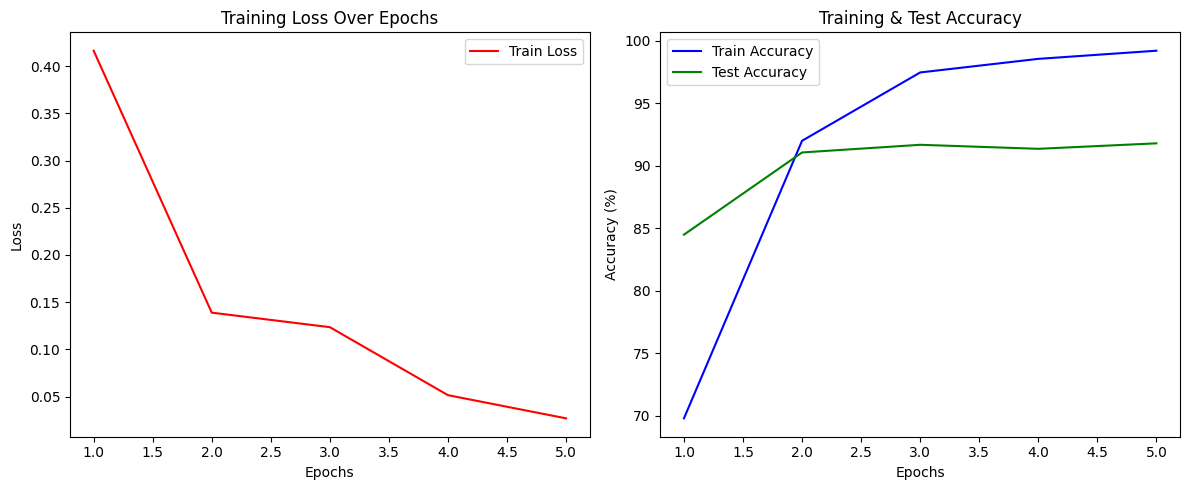

In [72]:
test_accuracies_1 = [float(value) * 100 for value in test_accuracies_str_1]

epochs = list(range(1, len(train_losses_1) + 1))

# Plotting train losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(epochs, train_losses_1, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plotting train and test accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies_1, label='Train Accuracy', color='blue')
plt.plot(epochs, test_accuracies_1, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training & Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model, os.path.join('/content/drive/MyDrive/models/res50', 'complete_model.pth'))

In [64]:
#Def_CustomNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes).to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [65]:
# Eval_customNet

def test(split):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = torch.sigmoid(outputs) if criterion == nn.BCEWithLogitsLoss else outputs
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)


            y_true = torch.cat((y_true.cpu(), targets.cpu()), 0)
            y_score = torch.cat((y_score.cpu(), outputs.cpu()), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
        numbers = re.findall(r'\d+.\d+', str(metrics))
        if split == 'test':
          test_losses_2.append(numbers[0])
          test_accuracies_str_2.append(numbers[1])


In [77]:
# Train_CustomNet
epoch_num = 0
for epoch in range(NUM_EPOCHS):
    train_correct_2 = 0
    train_total_2 = 0
    test_correct_2 = 0
    test_total_2 = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
            train_correct_2 += ((outputs > 0.5).int() == targets.int()).sum().item()
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        _, predicted = outputs.max(1)
        train_correct_2 += predicted.eq(targets).sum().item()

        loss.backward()
        optimizer.step()
        train_total_2 += targets.size(0)
    train_losses_2.append(loss.item())
    train_accuracies_2.append(100 * train_correct_2 / train_total_2)
    # torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/models/CustomNet/epoch2', f'model_epoch_{epoch}.pth'))
    epoch_num += 1
    print(epoch_num)
    print('==> Evaluating ...')
    test('train')
    test('test')

100%|██████████| 38/38 [00:02<00:00, 13.68it/s]


==> Evaluating ...
train  auc: 0.862  acc:0.492
['0.8616843874157432', '0.49193076344175934']
test  auc: 0.865  acc:0.502
['0.8650716304394892', '0.5021923414206373']


100%|██████████| 38/38 [00:03<00:00, 12.52it/s]


==> Evaluating ...
train  auc: 0.875  acc:0.529
['0.8746410237740883', '0.5293920896396019']
test  auc: 0.877  acc:0.540
['0.8772978000096461', '0.5401929260450161']


100%|██████████| 38/38 [00:02<00:00, 14.01it/s]


==> Evaluating ...
train  auc: 0.885  acc:0.556
['0.8854134394599356', '0.5563174178443013']
test  auc: 0.888  acc:0.562
['0.8875311664707435', '0.5618240280619702']


100%|██████████| 38/38 [00:03<00:00, 12.38it/s]


==> Evaluating ...
train  auc: 0.895  acc:0.569
['0.8952870709333388', '0.5692783677565014']
test  auc: 0.897  acc:0.575
['0.8967784305165951', '0.5746857643963753']


100%|██████████| 38/38 [00:02<00:00, 13.45it/s]


==> Evaluating ...
train  auc: 0.903  acc:0.584
['0.9034031594999545', '0.5839116983025336']
test  auc: 0.904  acc:0.582
['0.9043020197390028', '0.5817012569424145']


In [78]:
print(train_losses_2)
print(train_accuracies_2)
print(test_accuracies_str_2)

[1.87507963180542, 1.7894277572631836, 1.7690788507461548, 1.6792954206466675, 1.6193010807037354]
[47.09423864871645, 51.09122836357555, 54.260389664687686, 56.17526549042562, 57.75566518939711]
['0.5021923414206373', '0.5401929260450161', '0.5618240280619702', '0.5746857643963753', '0.5817012569424145']


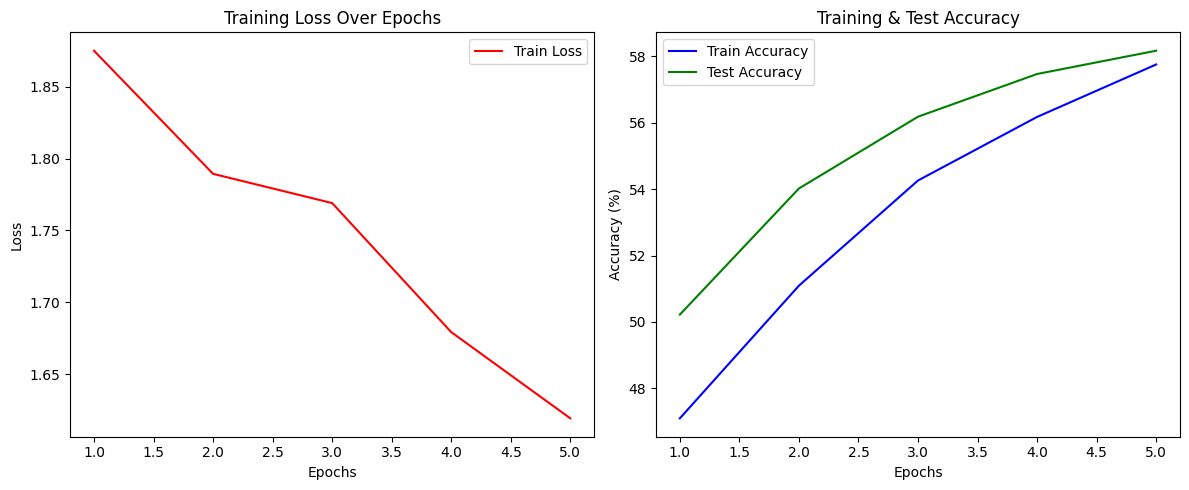

In [79]:
test_accuracies_2 = [float(value) * 100 for value in test_accuracies_str_2]

epochs = list(range(1, len(train_losses_2) + 1))

# Plotting train losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(epochs, train_losses_2, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plotting train and test accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies_2, label='Train Accuracy', color='blue')
plt.plot(epochs, test_accuracies_2, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training & Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Results:
The evaluation results provide insights into the effectiveness of the ResNet-50 and CustomNet models in classifying blood cell images. The achieved AUC and accuracy metrics demonstrate the models' ability to learn and generalize from the dataset.


Conclusion:
This project showcases the application of deep learning techniques to medical image classification using the MedMNIST dataset. The utilization of ResNet-50 and a custom CNN highlights the versatility of deep learning models in handling diverse medical image datasets. The obtained results contribute to the ongoing efforts to integrate AI technologies into healthcare for more accurate and efficient diagnostics.


**Future Work:
Future work may involve fine-tuning the models, exploring transfer learning techniques, and experimenting with other deep learning architectures. Additionally, incorporating larger and more diverse medical image datasets could further enhance the models' performance and generalization capabilities.

In conclusion, this project serves as a stepping stone for researchers and practitioners interested in leveraging deep learning for medical image classification, with a focus on the MedMNIST dataset and two different model architectures.
**